In [1]:
import torch
from kan import KAN, LBFGS
from tqdm import tqdm

from loss_functions import HeatMIMLoss
from data_generators import HeatDataGenerator

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
input_dims = 8
data_generator = HeatDataGenerator(256, input_dims)

model = KAN(width=[input_dims+1, input_dims+1], grid=5).to(DEVICE)
mim_loss_fn = HeatMIMLoss()

checkpoint directory created: ./model
saving model version 0.0


In [3]:
model

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train():
    steps = 100  # Same as before
    log = 1
    pbar = tqdm(range(steps), desc='Training Progress')

    for epoch in pbar:
        t, X, w, _ = data_generator()
        inp = torch.cat([t, X], dim=1).to(DEVICE)
        
        optimizer.zero_grad()
        output = model(inp)
        u = output[:, 0].view(-1, 1)
        p = output[:, 1:]
        residual, correction = mim_loss_fn(u, p, t, w, X)
        loss = residual + correction
        loss.backward()  # Compute gradients
        optimizer.step()  # Adam optimization step

        if epoch % 20 == 0:
            t, X, _, _ = data_generator()
            inp = torch.cat([t, X], dim=1).to(DEVICE)
            model.update_grid(inp)

        if epoch % log == 0:
            pbar.set_description("| loss: %.2e |" % residual.cpu().detach().numpy())


In [5]:
train()

| loss: 5.43e-04 |: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


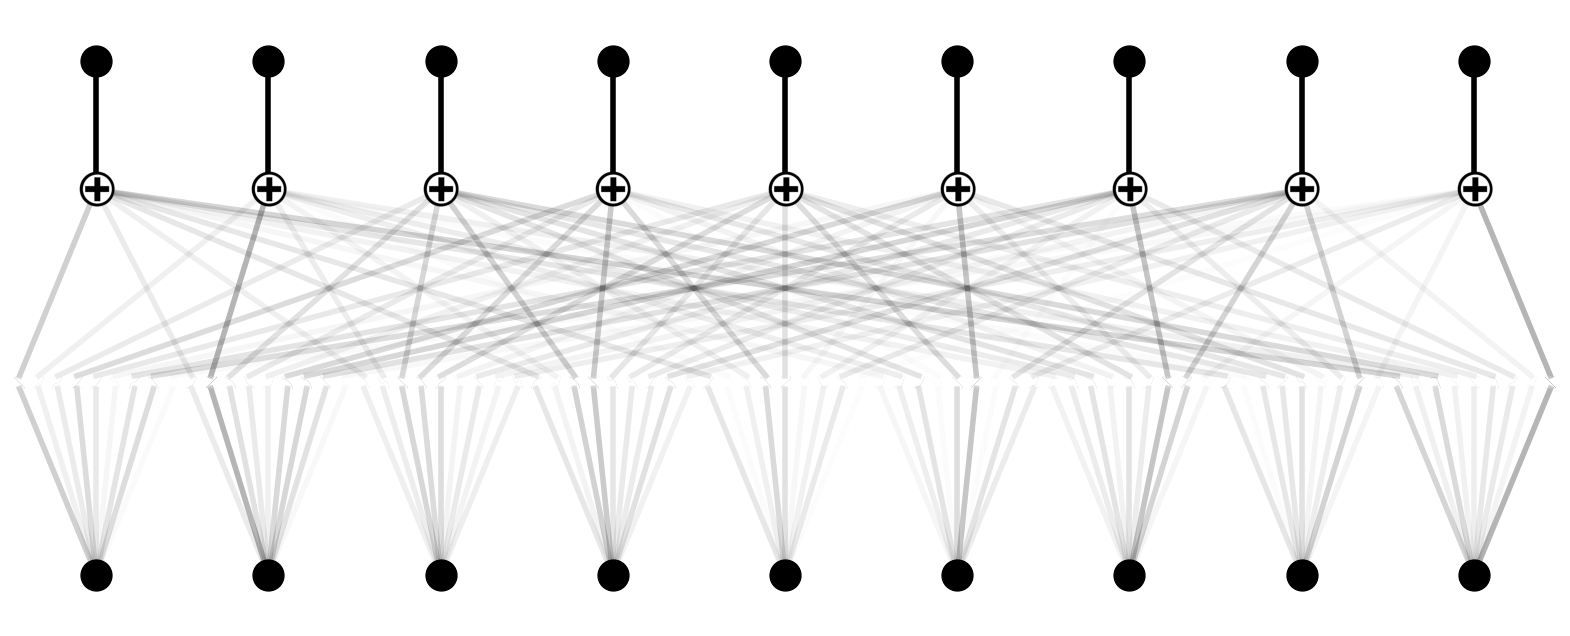

In [6]:
model.plot(scale=2)

In [7]:
model.prune()

saving model version 0.1


MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [8]:
model.auto_symbolic()

fixing (0,0,0) with x, r2=0.9999976754188538, c=1
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with x, r2=0.9849151372909546, c=1
fixing (0,0,4) with exp, r2=0.9993904829025269, c=2
fixing (0,0,5) with 0, r2=0.0, c=0
fixing (0,0,6) with x, r2=0.9399519562721252, c=1
fixing (0,0,7) with sin, r2=0.9994404911994934, c=2
fixing (0,0,8) with 0, r2=0.0, c=0
fixing (0,1,0) with x^2, r2=0.9999977946281433, c=2
fixing (0,1,1) with x, r2=0.9999468922615051, c=1
fixing (0,1,2) with 0, r2=0.0, c=0
fixing (0,1,3) with exp, r2=0.996893584728241, c=2
fixing (0,1,4) with 0, r2=0.0, c=0
fixing (0,1,5) with 0, r2=0.0, c=0
fixing (0,1,6) with 0, r2=0.0, c=0
fixing (0,1,7) with x, r2=0.9902744293212891, c=1
fixing (0,1,8) with 0, r2=0.0, c=0
fixing (0,2,0) with x, r2=0.9650608897209167, c=1
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with x, r2=0.9998264908790588, c=1
fixing (0,2,3) with cos, r2=0.9994820356369019, c=2
fixing (0,2,4) with x, r2=0.9863744378089

In [9]:
sf = model.symbolic_formula()[0][0]
sf

-0.186362978838282*x_1 - 0.0613903599640491*x_3 + 0.0791017181224007*(0.340779557052288 - x_6)**2 - 0.0997946947472854*(0.909722840355468 - x_4)**2 + 0.0701773561392271*(-x_2 - 0.0304228410569261)**2 + 0.0864591313621338*(-x_8 - 0.0160132628117556)**2 - 0.106850492517713*(-x_9 - 0.17637400380913)**2 + 0.0673138423253346*exp(0.830479860305786*x_5) + 0.0778488812637701

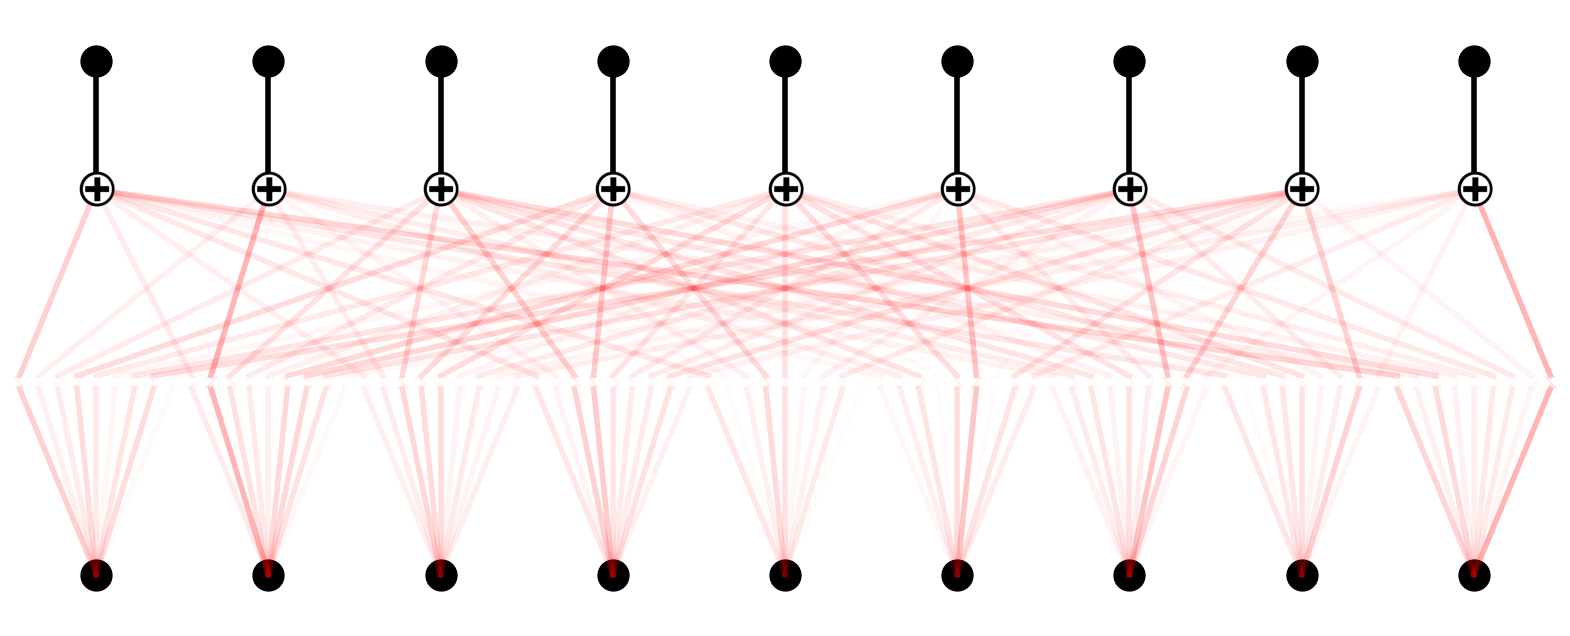

In [10]:
model.plot(scale=2)